Download and read the data

In [4]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True , exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url , tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets" , filter="data")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing_full = load_housing_data()

In [6]:
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing_full["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [9]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


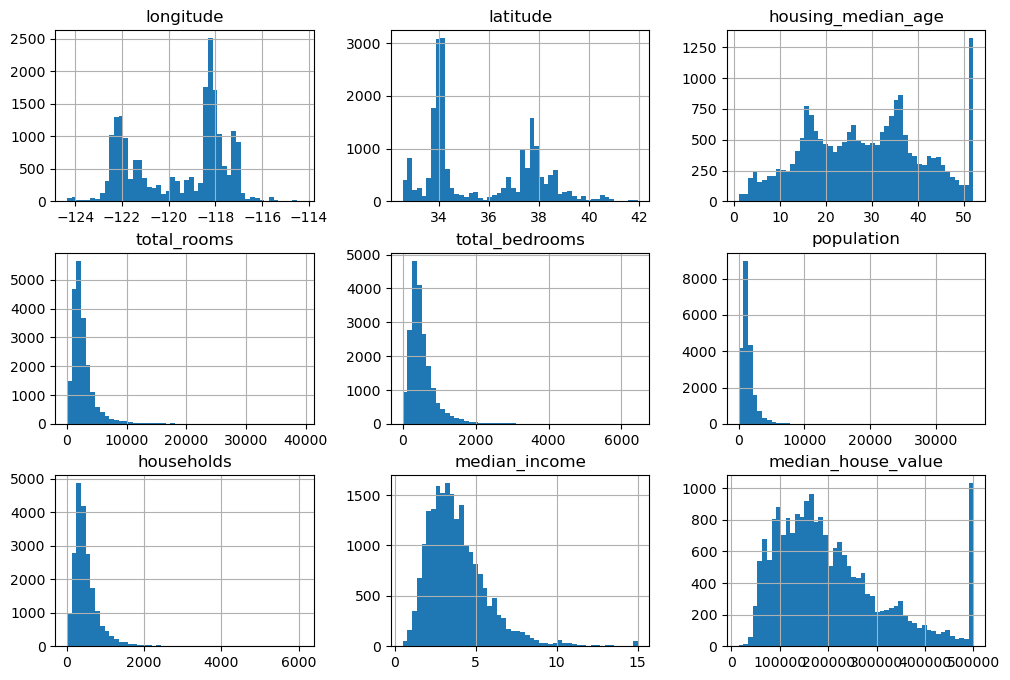

In [18]:
import matplotlib.pyplot as plt
housing_full.hist(bins = 50 , figsize=(12 , 8))
plt.show()

Create a random **test set**:

In [19]:
# Function that returns a shuffeled train set and test set of a given data
# BAD IMPLEMENTATION
def shuffle_and_split_data(data , test_ratio , rng):
    shuffled_indices = rng.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices] , data.iloc[test_indices]

In [24]:
import numpy as np

rng = np.random.default_rng() #default random number generator
train_set , test_set = shuffle_and_split_data(housing_full , 0.2 , rng) #use 20% of all data as test set

Problem is, that shuffle_and_split_data function always returns an slighly different train and test set. Over time, we would get to see the whole dataset. This should be avoided! We can compute a hash from the instance's unique ID and then decide in which set this instance shall be in.

In [25]:
from zlib import crc32

def is_id_in_test_set(identifier , test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

# Better implementation
def split_data_with_id_hash(data , test_ratio , id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_ , test_ratio))
    return data.loc[~in_test_set] , data.loc[in_test_set]

In [28]:
#Add the housing data a identifier column. Simplest solution: use the row index as the ID
housing_with_id = housing_full.reset_index() #adds an 'index' column

train_set , test_set = split_data_with_id_hash(housing_with_id , 0.2 , "index")


Current index approach is prone to errors if a instance gets deleted or we add a new instance NOT at the tail of the dataset. Now using a more stable approach by derive the identifier from the longitude and latitude information of a district.

In [29]:
housing_with_id["id"] = (housing_full["longitude"] * 100 + housing_full["latitude"])

train_set , test_set = split_data_with_id_hash(housing_with_id , 0.2 , "id")

In [50]:
#Now using the build-in function of scikit-learn to split the data
from sklearn.model_selection import train_test_split

train_set , test_set = train_test_split(housing_full , test_size=0.2 , random_state=42)

Use median income categories in order to avoid bias:

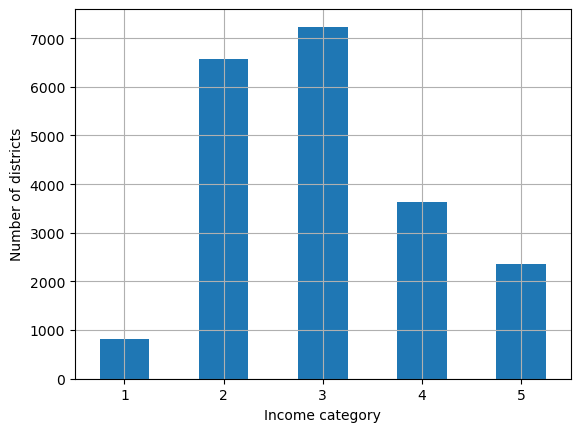

In [51]:
housing_full["income_cat"] = pd.cut(housing_full["median_income"] , bins=[0., 1.5 , 3.0 , 4.5 , 6. , np.inf] , \
                                   labels=[1 , 2 , 3 , 4 , 5])

cat_counts = housing_full["income_cat"].value_counts().sort_index()
cat_counts.plot.bar(rot=0 , grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

Now we are ready to do stratified sampling based on the income category. We will generate 10 different stratified splits of the same dataset:

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10 , test_size=0.2 , random_state=42)
strat_splits = []
for train_index , test_index in splitter.split(housing_full , housing_full["income_cat"]):
    strat_train_set_n = housing_full.iloc[train_index]
    strat_test_set_n = housing_full.iloc[test_index]
    strat_splits.append([strat_train_set_n , strat_test_set_n])

In [53]:
strat_train_set , strat_test_set = strat_splits[0] #get the first split

#alternativly, shorter:
#strat_train_set , strat_test_set = train_test_split(housing_full , test_size=0.2 , stratify=housing_full["income_cat"] , random_state=42)

Looking at the income category proportions in the test set:

In [54]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [55]:
housing_full["income_cat"].value_counts() / len(housing_full)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [57]:
train_set["income_cat"].value_counts()  / len(train_set)

income_cat
3    0.351926
2    0.321705
4    0.174358
5    0.112827
1    0.039184
Name: count, dtype: float64

"train_set" has biggest error compared to "housing_full", therefore "strat_test_set" is the most representative dataset without bias.

We won't use "income_cat" column again, so it will be dropped.

In [59]:
#for set_ in (strat_train_set , strat_test_set):
#    set_.drop("income_cat" , axis=1 , inplace=True)

To safely experiment with the traning set, we first make a copy of it.

In [60]:
housing = strat_train_set.copy()

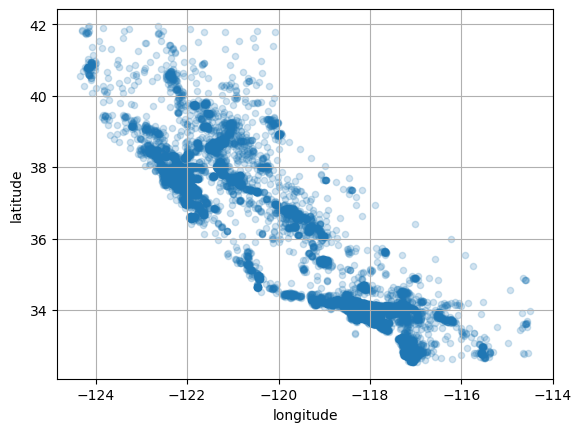

In [67]:
housing.plot(kind="scatter" , x="longitude" , y="latitude" , grid=True , alpha=0.2)
plt.show()